In [126]:
import numpy as np
import pandas as pd
import pandas_datareader as pdr
import datetime
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings(action='ignore') 

In [127]:
p = pd.read_csv("../../data/kosdaq/price.csv", index_col='date', parse_dates=True)
sn = pd.read_csv("../../data/kosdaq/share_number.csv", index_col='date', parse_dates=True)
pc = pd.read_csv("../../data/kosdaq/price_mod.csv", index_col = 'date', parse_dates = True)
pl = pd.read_csv("../../data/kosdaq/price_low.csv", index_col = 'date', parse_dates = True)
ph = pd.read_csv("../../data/kosdaq/price_high.csv", index_col = 'date', parse_dates = True)
po = pd.read_csv("../../data/kosdaq/price_open.csv", index_col = 'date', parse_dates = True)

# quality
gp_t = pd.read_csv("../../data/kosdaq/gross_profit.csv", index_col='date', parse_dates=True)
ast_t = pd.read_csv("../../data/kosdaq/asset.csv", index_col='date', parse_dates=True)
lb_t = pd.read_csv("../../data/kosdaq/liability.csv", index_col = 'date', parse_dates = True)
cf_t = pd.read_csv("../../data/kosdaq/cashflow.csv", index_col = 'date', parse_dates = True)
sl_t = pd.read_csv("../../data/kosdaq/sales.csv", index_col = 'date', parse_dates = True)

# value
per_t = pd.read_csv("../../data/kosdaq/per.csv", index_col = 'date', parse_dates = True)
pbr_t = pd.read_csv("../../data/kosdaq/pbr.csv", index_col = 'date', parse_dates = True)
psr_t = pd.read_csv("../../data/kosdaq/psr.csv", index_col = 'date', parse_dates = True)
pcr_t = pd.read_csv("../../data/kosdaq/pcr.csv", index_col = 'date', parse_dates = True)

# bps_t = pd.read_csv(f"../../data/kosdaq/quarter_bps.csv", index_col = 'date', parse_dates = True)
# eps_t = pd.read_csv(f"../../data/kosdaq/quarter_eps.csv", index_col = 'date', parse_dates = True)
# cfps_t = pd.read_csv(f"../../data/kosdaq/quarter_cfps.csv", index_col = 'date', parse_dates = True)
# sps_t = pd.read_csv(f"../../data/kosdaq/quarter_sps.csv", index_col = 'date', parse_dates = True)

# 거래정지
suspension = pd.read_csv("../../data/kosdaq/suspension.csv", index_col="date", parse_dates=True, low_memory=False)

In [128]:
# 중국기업 제외
chinese = ['A900110', 'A900120', 'A900070', 'A900080', 'A900250', 'A900260', 'A900270', 'A900280', \
           'A900290', 'A900300', 'A900310', 'A900340', 'A900090', 'A060240']
p.drop(chinese, axis=1, inplace=True)
sn.drop(chinese, axis=1, inplace=True)
pc.drop(chinese, axis=1, inplace=True)
po.drop(chinese, axis=1, inplace=True)
ph.drop(chinese, axis=1, inplace=True)
pl.drop(chinese, axis=1, inplace=True)
gp_t.drop(chinese, axis=1, inplace=True)
ast_t.drop(chinese, axis=1, inplace=True)
lb_t.drop(chinese, axis=1, inplace=True)
cf_t.drop(chinese, axis=1, inplace=True)
sl_t.drop(chinese, axis=1, inplace=True)
per_t.drop(chinese, axis=1, inplace=True)
pbr_t.drop(chinese, axis=1, inplace=True)
psr_t.drop(chinese, axis=1, inplace=True)
pcr_t.drop(chinese, axis=1, inplace=True)
suspension.drop(chinese, axis=1, inplace=True)

In [129]:
# 거래정지 처리
suspension.index = suspension.index + pd.tseries.offsets.MonthEnd(0)
m_suspension_mask = suspension.groupby('date').last().isnull()

# 빠진 기업 정리
pl.drop(list(set(pl) - set(p.columns)), axis=1, inplace=True)
pc.drop(list(set(pc) - set(p.columns)), axis=1, inplace=True)
po.drop(list(set(po) - set(p.columns)), axis=1, inplace=True)
ph.drop(list(set(ph) - set(p.columns)), axis=1, inplace=True)

In [130]:
m = 15

market_cap = p * sn
market_cap_t = market_cap.copy()
market_cap_t.index = market_cap_t.index + pd.tseries.offsets.MonthEnd(0)
m_cap = market_cap_t.groupby('date').last()

pc_t = pc.copy()
pc_t.index = pc_t.index + pd.tseries.offsets.MonthEnd(0)
m_pc = pc_t.groupby('date').last()
m_ret = (m_pc.fillna(-1) / m_pc.shift(1)).clip(0, 10) - 1

gp = pd.DataFrame(index=m_ret.index).join(gp_t).shift(m)
ast = pd.DataFrame(index=m_ret.index).join(ast_t).shift(m)
lb = pd.DataFrame(index=m_ret.index).join(lb_t).shift(m)
cf = pd.DataFrame(index=m_ret.index).join(cf_t).shift(m)
sl = pd.DataFrame(index=m_ret.index).join(sl_t).shift(m)

p_t = p.copy()
p_t.index = p_t.index + pd.tseries.offsets.MonthEnd(0)
m_p = p_t.groupby('date').last()

per = per_t.shift(m)
pbr = pbr_t.shift(m)
psr = psr_t.shift(m)
pcr = pcr_t.shift(m)

pl_t = pl.copy()
po_t = po.copy()
ph_t = ph.copy()

pl_t.index = pl_t.index + pd.tseries.offsets.MonthEnd(0)
po_t.index = po_t.index + pd.tseries.offsets.MonthEnd(0)
ph_t.index = ph_t.index + pd.tseries.offsets.MonthEnd(0)

In [131]:
# quality
pivot = 12

# 수익성 팩터
gpoa = gp/ast # gross profit over asset
cfoa = cf/ast # cashflow profit over asset
gmar = gp/sl  # gross margin
turn = sl/ast

# 성장성 팩터(수익성 팩터, 5년 전과 비교해서 변화 정도 / 총자산)
gpoa_d = (gpoa - gpoa.shift(pivot))/ ast.shift(pivot)
cfoa_d = (cfoa - cfoa.shift(pivot))/ ast.shift(pivot)
gmar_d = (gmar - gmar.shift(pivot))/ sl.shift(pivot)
turn_d = sl/ast - sl.shift(12)/ast.shift(12)

# 안정성 팩터
lev = lb/ast # 총부채 / 총자산
gpvol = gpoa.rolling(pivot).std()  # gross profit volatility
cfvol = cfoa.rolling(pivot).std()  # cashflow volatility

gpoa_rank = gpoa.rank(axis=1, ascending=False)
cfoa_rank = cfoa.rank(axis=1, ascending=False)
gmar_rank = gmar.rank(axis=1, ascending=False)
turn_rank = turn.rank(axis=1, ascending=False)
gpoa_d_rank = gpoa_d.rank(axis=1, ascending=False)
cfoa_d_rank = cfoa_d.rank(axis=1, ascending=False)
gmar_d_rank = gmar_d.rank(axis=1, ascending=False)
turn_d_rank = turn_d.rank(axis=1, ascending=False)
lev_rank = lev.rank(axis=1)
gpvol_rank = gpvol.rank(axis=1)
cfvol_rank = cfvol.rank(axis=1)

gpoa_z = (gpoa_rank.T - gpoa_rank.mean(axis=1)) / gpoa_rank.std(axis=1)
cfoa_z = (cfoa_rank.T - cfoa_rank.mean(axis=1)) / cfoa_rank.std(axis=1)
gmar_z = (gmar_rank.T - gmar_rank.mean(axis=1)) / gmar_rank.std(axis=1)
turn_z = (turn_rank.T - turn_rank.mean(axis=1)) / turn_rank.std(axis=1)
gpoa_d_z = (gpoa_d_rank.T - gpoa_d_rank.mean(axis=1)) / gpoa_d_rank.std(axis=1)
cfoa_d_z = (cfoa_d_rank.T - cfoa_d_rank.mean(axis=1)) / cfoa_d_rank.std(axis=1)
gmar_d_z = (gmar_d_rank.T - gmar_d_rank.mean(axis=1)) / gmar_d_rank.std(axis=1)
turn_d_z = (turn_d_rank.T - turn_d_rank.mean(axis=1)) / turn_d_rank.std(axis=1)
lev_z = (lev_rank.T - lev_rank.mean(axis=1)) / lev_rank.std(axis=1)
gpvol_z = (gpvol_rank.T - gpvol_rank.mean(axis=1)) / gpvol_rank.std(axis=1)
cfvol_z = (cfvol_rank.T - cfvol_rank.mean(axis=1)) / cfvol_rank.std(axis=1)

total_qz = gpoa_z.T + cfoa_z.T + gmar_z.T + turn_z.T + gpoa_d_z.T + cfoa_d_z.T + gmar_d_z.T + turn_d_z.T + lev_z.T + gpvol_z.T + cfvol_z.T
total_qz = ((total_qz.T - total_qz.mean(axis=1)) / total_qz.std(axis=1)).T

In [132]:
# value
per_rank = per.rank(axis=1, pct=True)
pbr_rank = pbr.rank(axis=1, pct=True)
psr_rank = psr.rank(axis=1, pct=True)
pcr_rank = pcr.rank(axis=1, pct=True)

per_z = ((per_rank.T - per_rank.mean(axis=1)) / per_rank.std(axis=1))
pbr_z = ((pbr_rank.T - pbr_rank.mean(axis=1)) / pbr_rank.std(axis=1))
psr_z = ((psr_rank.T - psr_rank.mean(axis=1)) / psr_rank.std(axis=1))
pcr_z = ((pcr_rank.T - pcr_rank.mean(axis=1)) / pcr_rank.std(axis=1))

total_vz = per_z.T + pbr_z.T + psr_z.T + pcr_z.T

In [133]:
def MDD(arr):
    low = np.argmin(arr / np.maximum.accumulate(arr))
    high = np.argmax(arr[:low])
    return high, low, (arr[high] - arr[low]) / arr[high]

def hit_ratio(arr, r, recent_num_ratio=True):
    total = round(sum(arr > 0) / len(arr), 4)
    recent = round(sum(arr[-1*r:] > 0) / len(arr[-1*r:]), 4) if recent_num_ratio else sum(arr[-1*r:] > 0)
    return total, recent

In [134]:
vol_month = m_pc.rolling(50).std()
vol_day = (pc_t.fillna(-1) / pc_t.shift(1)).clip(0, 10).rolling(50).std().groupby('date').mean()
momentum_mask_t = m_pc.copy()
for i in range(6):
    momentum_mask_t[momentum_mask_t < m_pc.shift(i)] = m_pc.shift(i)[momentum_mask_t < m_pc.shift(i)]
momentum = (m_pc.shift(1) / m_pc.shift(4)) - (m_pc / momentum_mask_t) - vol_day * 1.5

momentum_mask = m_pc.shift(1).copy()
for i in range(9):
    momentum_mask[momentum_mask > m_pc.shift(i)] = m_pc.shift(i)[momentum_mask > m_pc.shift(i)]
momentum_mask = (m_pc.shift(1) / momentum_mask) < 2

In [135]:
per_minus_mask = (per.shift(12).isnull() & m_pc.shift(15+12).notnull()) & \
                (per.shift(24).isnull() & m_pc.shift(15+24).notnull()) & \
                (per.shift(36).isnull() & m_pc.shift(15+36).notnull()) & \
                (per.shift(48).isnull() & m_pc.shift(15+48).notnull())

momentum: high - 2018-08-31 00:00:00, low - 2018-10-31 00:00:00, mdd - 0.2714
value (hit): total - 0.7, recent - 9


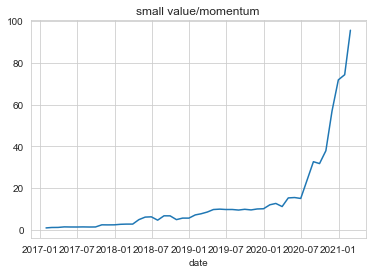

In [148]:
small_mask = m_cap[m_suspension_mask].rank(axis=1, pct=True, ascending=False) > 0.9
sv_mask = total_vz[small_mask].rank(axis=1, pct=True) < 0.2
sm_mask = momentum[sv_mask & momentum_mask & ~per_minus_mask].rank(axis=1, pct=True, ascending=False) < 0.4
sm_cap_weight = (m_cap[sm_mask].T / m_cap[sm_mask].sum(axis=1)).T

pr = 192 + 12
sm_r = m_ret[sm_mask.shift(1)].mean(axis=1).fillna(0)
sm_cr = (sm_r + 1)[pr:].cumprod()

h, l, mdd = MDD(sm_cr.values)
print(f'momentum: high - {sm_cr.index[h]}, low - {sm_cr.index[l]}, mdd - {round(mdd, 4)}')
# t = 130
# h, l, mdd = MDD(sm_cr[t:].values)
# print(f'momentum: high - {sm_cr[t:].index[h]}, low - {sm_cr[t:].index[l]}, mdd - {round(mdd, 4)}')

t, r = hit_ratio(sm_r.values[pr:], 12, False)
print(f'value (hit): total - {t}, recent - {r}')

sns.set_style('whitegrid')
sns.lineplot(sm_cr.index, sm_cr)
plt.title('small value/momentum')
plt.show()

# print('투자 기업 개수')
# print(sm_mask[-30:].sum(axis=1).values)
# print(svol_mask[-30:].sum(axis=1).values)
# print()

# print('평균 수익률')
# print(sm_r.mean(), svol_r.mean())
# print()

# print('수익률 표준편차')
# print(sm_r.std(), svol_r.std())
# print()

# print('수익률 상관관계')
# print(sm_r.corr(svol_r))

momentum: high - 2018-05-31 00:00:00, low - 2020-03-31 00:00:00, mdd - 0.5584
value (hit): total - 0.58, recent - 7


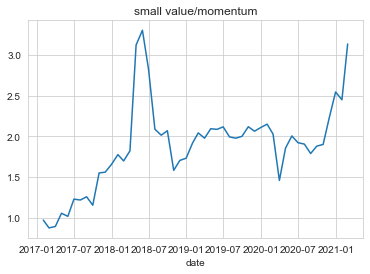

In [139]:
small_mask = m_cap[m_suspension_mask].rank(axis=1, pct=True, ascending=False) > 0.8
sq_mask = total_qz[small_mask].rank(axis=1, pct=True) < 0.3
sv_mask = total_vz[sq_mask].rank(axis=1, pct=True) < 0.2
sm_mask = momentum[sv_mask & momentum_mask & ~per_minus_mask].rank(axis=1, pct=True, ascending=False) < 0.4
sm_cap_weight = (m_cap[sm_mask].T / m_cap[sm_mask].sum(axis=1)).T

pr = 192 + 12
sm_r = m_ret[sm_mask.shift(1)].mean(axis=1).fillna(0)
sm_cr = (sm_r + 1)[pr:].cumprod()

h, l, mdd = MDD(sm_cr.values)
print(f'momentum: high - {sm_cr.index[h]}, low - {sm_cr.index[l]}, mdd - {round(mdd, 4)}')
# t = 130
# h, l, mdd = MDD(sm_cr[t:].values)
# print(f'momentum: high - {sm_cr[t:].index[h]}, low - {sm_cr[t:].index[l]}, mdd - {round(mdd, 4)}')

t, r = hit_ratio(sm_r.values[pr:], 12, False)
print(f'value (hit): total - {t}, recent - {r}')

sns.set_style('whitegrid')
sns.lineplot(sm_cr.index, sm_cr)
plt.title('small value/momentum')
plt.show()

In [140]:
print(sm_mask[-30:].sum(axis=1).values)

[3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 2 3 3 3 3 3 3 3 3 2 2]


In [124]:
idx = list(sm_mask.iloc[-1][sm_mask.iloc[-1]==True].index)
code_df = pd.read_html('http://kind.krx.co.kr/corpgeneral/corpList.do?method=download', header=0)[0][['회사명', '종목코드']]
for i in range(len(idx)):
    print(code_df.query(f'종목코드=={int(idx[i][1:])}').values[0][0], idx[i][1:])#, m_pc.iloc[-1][idx[i]])

URLError: <urlopen error [Errno 8] nodename nor servname provided, or not known>

In [13]:
# sv100 중 상폐된 기업과 폐지된 월: 없음!
mask = sm_mask
delist_total = (m_ret==-1)
delist_temp = delist_total[delist_total==True]
for i in range(0, len(mask) - 1):
    zero_r = set(delist_temp.iloc[i+1].dropna().index)
    idx = set(mask[mask==True].iloc[i].dropna().index)
    if idx & zero_r:
        print(mask.index[i], idx & zero_r)

In [14]:
# 종목코드 : 회사명 으로 변경
code_df = pd.read_html('http://kind.krx.co.kr/corpgeneral/corpList.do?method=download', header=0)[0][['회사명', '종목코드']]
code_df.index = ['A'+'%06d' %i for i in code_df['종목코드']]
del code_df['종목코드']

In [141]:
pc = pc[:-9]
for i in [po, pl, ph]:
    i.drop(set(i.index) - set(pc.index), inplace=True)
pl = pl[pc.columns]
po = po[pc.columns]
ph = ph[pc.columns]
pl_t = pl.copy()
po_t = po.copy()
ph_t = ph.copy()
pc_t = pc.copy()
pl_t.index = pl_t.index + pd.tseries.offsets.MonthEnd(0)
po_t.index = po_t.index + pd.tseries.offsets.MonthEnd(0)
ph_t.index = ph_t.index + pd.tseries.offsets.MonthEnd(0)
pc_t.index = pc_t.index + pd.tseries.offsets.MonthEnd(0)

In [163]:
# 캔들의 윗꼬리가 길 때 차익을 남기는 전략
# drop_line 이상 올라가면 팔고 당일에 rebuy_line이하로 내려가면 재매수
# 당일에 팔고 재매수하지 않았으면 월초가격 이하로 내려가면 재매수
m_ret_t = m_ret.copy()
m_ret_t[:] = 0.0

print_flag = 0
start = 132
drop_line = 1 + 0.05
rebuy_line = 1 + 0.01
for i in range(start, len(sm_mask)-2):
    portfolio = sm_mask.iloc[i][sm_mask.iloc[i]==True].index
    start_price = pc_t.loc[sm_mask.index[i]].iloc[-1]

    date = sm_mask.index[i+1]
    m_po_t = po_t.loc[date][portfolio]
    m_pc_t = pc_t.loc[date][portfolio]
    m_ph_t = ph_t.loc[date][portfolio]
    m_pl_t = pl_t.loc[date][portfolio]
    
    # buy: 매수가격,  dropped: 팔고 다시 사지 못한 종목, profit_val: 수익금
    # to_buy: 재매수 때 사아야할 가격(지난 달 종가 * rebuy_line), dropped==True인 종목만 유의미
    port_info = pd.DataFrame(index=portfolio, columns = ['buy', 'to_buy', 'dropped', 'profit_val'])
    port_info['buy'] = start_price[portfolio]
    port_info['dropped'] = False
    port_info['profit_val'] = 0
    
    rebuy_flag = 0
    for j in range(0, len(pc_t.loc[date])):
        drop = (m_ph_t.iloc[j] / m_po_t.iloc[j]) > drop_line
        rebuy = (m_pc_t.iloc[j] / m_po_t.iloc[j]) < rebuy_line
        
        if print_flag and drop.sum():
            print(port_info)
        # 이전에 팔고 사지 못한 종목이 있는 경우 재구매 체크
        if port_info['dropped'].sum():
            dropped_idx = port_info[port_info['dropped']==True].index
            buy = (m_pl_t.iloc[j][dropped_idx] < port_info.loc[dropped_idx]['to_buy'])
            buy_idx = buy[buy==True].index
            # 재구매가 가능한 종목이 있는 경우 당일 종가로 구매
            if list(buy_idx):
                port_info['buy'][buy_idx] = m_pc_t.iloc[j][buy_idx]
                port_info['dropped'][buy_idx] = False
                if print_flag:
                    print('buy later')
                    print(port_info)
                    print('----------*2')
        
        drop_idx = list(set(drop[drop==True].index) & set(port_info[port_info['dropped']==False].index))
        rebuy_idx = list(set(drop_idx) & set(rebuy[rebuy==True].index))
        dropped_idx = list(set(drop_idx) - set(rebuy_idx)) # 팔고 사지 못한 종목
        port_info['profit_val'][drop_idx] +=  (m_po_t.iloc[j][drop_idx] * drop_line - port_info.loc[drop_idx]['buy'])
        port_info['buy'][rebuy_idx] = start_price[dropped_idx] * rebuy_line
        port_info['dropped'][dropped_idx] = True
        port_info['to_buy'][dropped_idx] =  start_price[dropped_idx] * rebuy_line
        
        # profit_val과 월말가격으로 수익률 계산
        if j == len(pc_t.loc[date]) - 1:
            inport_idx = port_info[port_info['dropped']==False].index
            port_info['profit_val'][inport_idx] += m_pc_t.iloc[j][inport_idx] - port_info['buy'][inport_idx]
            m_ret_t.loc[date][portfolio] = port_info['profit_val'] / start_price[portfolio]
            if print_flag and rebuy_flag:
                print(m_ret_t.loc[date][portfolio])
                print(m_ret.loc[date][portfolio])
        if print_flag and drop.sum():
            rebuy_flag = 1
            print(drop)
            print(rebuy)
            print(port_info)
            print('-------------'*4)
    if print_flag:
        print('------------------new month-------------------')

In [164]:
# 원래 전략 vs 당일매매 차익
start = 132# + 60
sm_r = m_ret[sm_mask.shift(1)].mean(axis=1).fillna(0)
sm_cr = (sm_r + 1)[start:].cumprod()

sm_rt = m_ret_t[sm_mask.shift(1)].mean(axis=1).fillna(0)
sm_crt = (sm_rt + 1)[start:].cumprod()

print(sm_cr[-1], sm_crt[-1])

46566.542809335464 53.780679113732134


In [162]:
# drop한 뒤 rebuy한 경우 / drop하고 rebuy하지 못한 경우 비율
start = 20
drop = 1 + 0.07
rebuy = 1 + 0.03
drop_rebuy_cnt = 0
drop_cnt = 0
t1 = ((po_t * drop) < ph_t)
t2 = ((po_t * drop) < ph_t) & (pc_t < (po_t * rebuy))

for i in range(start, len(sm_mask)-2):
    portfolio = sm_mask.iloc[i][sm_mask.iloc[i]==True].index
    drop_cnt += t1.loc[sm_mask.index[i+1]][portfolio].sum(axis=1).sum()
    drop_rebuy_cnt += t2.loc[sm_mask.index[i+1]][portfolio].sum(axis=1).sum()
    
print(drop_rebuy_cnt / drop_cnt)

0.2665350444225074


In [176]:
# 고가 / 시가 평균
sm_mask_daily = pd.DataFrame(index=p.index).join(sm_mask).ffill()
(ph / po)[sm_mask_daily].mean(axis=1).dropna().mean()

1.028943805931871